# Import library

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime as dt
from xgboost import XGBClassifier 
from catboost import Pool,CatBoostClassifier
from lightgbm import LGBMClassifier

% matplotlib inline
seed = 129

# Import Dataset

In [2]:
#path = '../input/'
path = ''
train = pd.read_csv(path+'train_v2.csv',dtype={'is_churn':np.int8})
test = pd.read_csv(path+'sample_submission_v2.csv',dtype={'is_churn':np.int8})
members = pd.read_csv(path+'members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv(path+'transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv(path+'user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

# Explore data set

In [33]:
print('Number of rows  & columns',train.shape)
train.head()

Number of rows  & columns (970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [4]:
print('Number of rows  & columns',test.shape)
test.head()

Number of rows  & columns (907471, 2)


,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [34]:
print('Number of rows  & columns',members.shape)
members.head()

Number of rows  & columns (6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


In [35]:
print('Number of rows & columns',transactions.shape)
transactions.head()

Number of rows & columns (1431009, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,42,42,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,-107,-107,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,-76,-76,1,2017-03-03,2017-04-22,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,-76,-76,1,2017-03-29,2017-03-31,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0


In [37]:
print('Number of rows & columns',user_log.shape)
user_log.head()

Number of rows & columns (18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,2017-03-31,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,2017-03-31,2,1,0,1,112,93,28401.558


In [38]:
print('\nTrain:',train.describe().T)
print('\nTest:',test.describe().T)
print('\nMembers:',members.describe().T)
print('\nTransactions:',transactions.describe().T)
print('\nUser log:',user_log.describe().T)



Train:              count      mean       std  min  25%  50%  75%  max
is_churn  970960.0  0.089942  0.286099  0.0  0.0  0.0  0.0  1.0

Test:              count  mean  std  min  25%  50%  75%  max
is_churn  907471.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Members:                     count      mean        std    min  25%  50%   75%    max
city            6769473.0  3.847358   5.478359    1.0  1.0  1.0   4.0   22.0
bd              6769473.0  9.763688  15.354561 -128.0  0.0  0.0  21.0  126.0
registered_via  6769473.0  5.253069   2.361398   -1.0  4.0  4.0   7.0   19.0

Transactions:                         count       mean        std    min    25%   50%   75%  \
payment_method_id   1431009.0  37.918355   4.964805    2.0   36.0  40.0  41.0   
payment_plan_days   1431009.0  18.432050  39.830162 -117.0   30.0  30.0  30.0   
plan_list_price     1431009.0 -21.387690  94.768896 -127.0 -107.0 -76.0  99.0   
actual_amount_paid  1431009.0 -20.556024  94.926916 -127.0 -107.0 -76.0  99.0   
is_auto_r

# Merge data set

In [3]:
train = pd.merge(train,members,on='msno',how='left')
test = pd.merge(test,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,transactions,how='left',on='msno',left_index=True, right_index=True,)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)
test = pd.merge(test,user_log,how='left',on='msno',left_index=True, right_index=True)

del members,transactions,user_log
print('Number of rows & columns',train.shape)
print('Number of rows & columns',test.shape)


Number of rows & columns (970960, 23)
Number of rows & columns (907471, 23)


# Date feature

In [4]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

,registration_init_time,transaction_date,membership_expire_date,date
count,860967,970960,970960,970960
unique,4749,820,1818,31
top,2015-10-09 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,1575,130414,79283,32331
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-04-24 00:00:00,2017-03-31 00:00:00,2036-10-15 00:00:00,2017-03-31 00:00:00


In [5]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    109993
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

In [6]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))
test['registration_init_time'] = test['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

In [7]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    #df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)
date_feature(test)

# Data analysis 

In [8]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'reg_day', 'reg_weekday', 'reg_month', 'reg_year',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_year',
       'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month', 'mem_exp_year',
       'user__day', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

# Missing value

In [9]:
train.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time         0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
date                           0
num_25                         0
num_50                         0
num_75                         0
num_985                        0
num_100                        0
num_unq                        0
total_secs                     0
reg_day                        0
reg_weekday                    0
reg_month                      0
reg_year                       0
trans_day                      0
trans_weekday                  0
trans_month                    0
trans_year

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 39 columns):
msno                      970960 non-null object
is_churn                  970960 non-null int8
city                      860967 non-null float64
bd                        860967 non-null float64
gender                    388905 non-null object
registered_via            860967 non-null float64
registration_init_time    970960 non-null datetime64[ns]
payment_method_id         970960 non-null int8
payment_plan_days         970960 non-null int8
plan_list_price           970960 non-null int8
actual_amount_paid        970960 non-null int8
is_auto_renew             970960 non-null int8
transaction_date          970960 non-null datetime64[ns]
membership_expire_date    970960 non-null datetime64[ns]
is_cancel                 970960 non-null int8
date                      970960 non-null datetime64[ns]
num_25                    970960 non-null int16
num_50                    970960 non

In [11]:
train.head().T

,0,1,2,3,4
msno,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=
is_churn,1,1,1,1,1
city,5,13,13,1,13
bd,28,20,18,0,35
gender,male,male,male,NaN,female
registered_via,3,3,3,7,7
registration_init_time,2013-12-23 00:00:00,2013-12-23 00:00:00,2013-12-27 00:00:00,2014-01-09 00:00:00,2014-01-25 00:00:00
payment_method_id,32,41,36,36,41
payment_plan_days,90,30,30,30,30
plan_list_price,42,-107,-76,-76,99


In [12]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train,col)
missing(test,col)

In [13]:
def unique_value(df):
    col = df.columns
    for i in col:
        print('Number of unique value in {} is {}'.format(i,df[i].nunique()))

unique_value(train)

Number of unique value in msno is 970960
Number of unique value in is_churn is 2
Number of unique value in city is 21
Number of unique value in bd is 186
Number of unique value in gender is 2
Number of unique value in registered_via is 5
Number of unique value in registration_init_time is 4749
Number of unique value in payment_method_id is 37
Number of unique value in payment_plan_days is 30
Number of unique value in plan_list_price is 44
Number of unique value in actual_amount_paid is 47
Number of unique value in is_auto_renew is 2
Number of unique value in transaction_date is 820
Number of unique value in membership_expire_date is 1818
Number of unique value in is_cancel is 2
Number of unique value in date is 31
Number of unique value in num_25 is 361
Number of unique value in num_50 is 179
Number of unique value in num_75 is 94
Number of unique value in num_985 is 218
Number of unique value in num_100 is 586
Number of unique value in num_unq is 430
Number of unique value in total_se

# is_churn

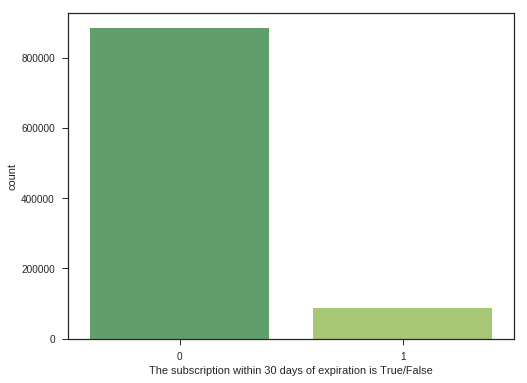

In [14]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration is True/False')

Imbalanced data set

msno: user id

is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. 
is_churn = 1 means churn,is_churn = 0 means renewal.

## Univariate analysis

[  5.  13.   1.  22.   9.  12.   6.  14.   4.  15.  18.   3.  21.   8.   7.
  17.  11.  10.  20.  16.  19.]


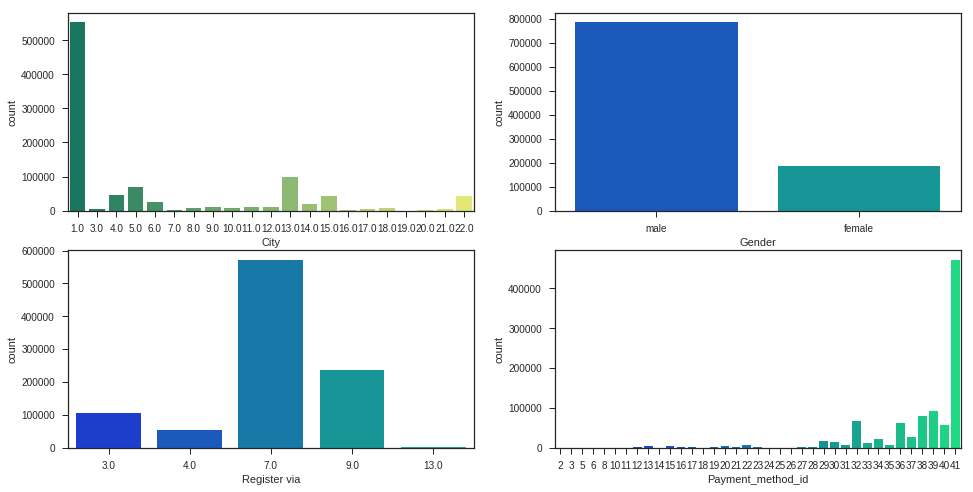

In [15]:
print(train['city'].unique())
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()

sns.set(style="ticks")
sns.countplot(train['city'],palette='summer',ax=ax1)
#ax1.set_yscale('log')

ax1.set_xlabel('City')
#ax1.set_xticks(rotation=45)

sns.countplot(x='gender',data = train,palette='winter',ax=ax2)
#ax2.set_yscale('log')
ax2.set_xlabel('Gender')

sns.countplot(x='registered_via',data=train,palette='winter',ax=ax3)
#ax3.set_yscale('')
ax3.set_xlabel('Register via')

sns.countplot(x='payment_method_id',data= train,palette='winter',ax=ax4)
ax4.set_xlabel('Payment_method_id')



# bd  (birth day)

In [16]:
print(train['bd'].describe())

count    970960.000000
mean         11.941948
std          15.811148
min        -128.000000
25%           0.000000
50%           0.000000
75%          26.000000
max         126.000000
Name: bd, dtype: float64


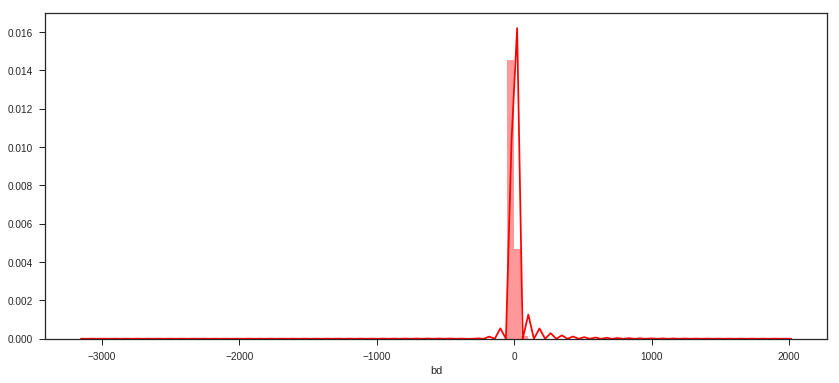

In [45]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
sns.set_style('ticks')
sns.distplot(train['bd'].fillna(train['bd'].mode()[0]),bins=100,color='r',ax=ax1)
plt.title('Distribution of birth day')

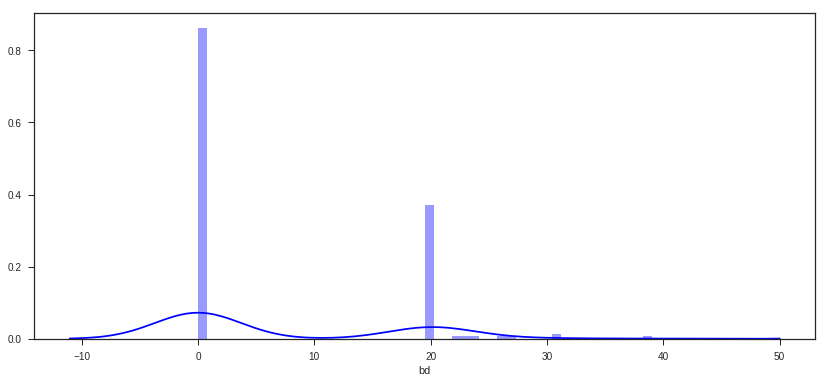

In [23]:
plt.figure(figsize=(14,6))
sns.distplot(train.loc[train['bd'].value_counts()]['bd'].fillna(0),bins=50,color='b')

# Gender

In [21]:
print(pd.crosstab(train['is_churn'],train['gender']))

gender    female    male
is_churn                
0         160404  723226
1          23940   63390


Number of unique value ['male' 'female']


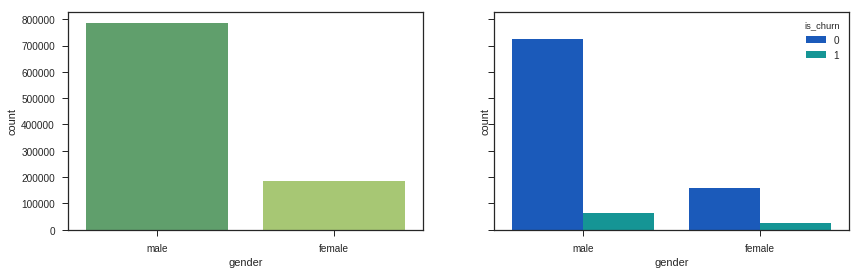

In [21]:
print('Number of unique value',train['gender'].unique())

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(14,4))

sns.set_style('ticks')
sns.countplot(train['gender'],palette='summer',ax=ax1)

sns.countplot(data=train,x='gender',palette='winter',hue='is_churn',ax=ax2)
#plt.tight_layout


# registered_via

Number of unique value [  7.   3.   9.   4.  13.]


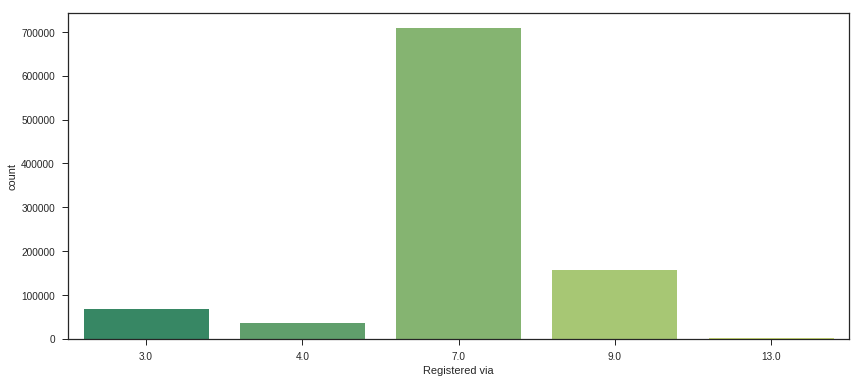

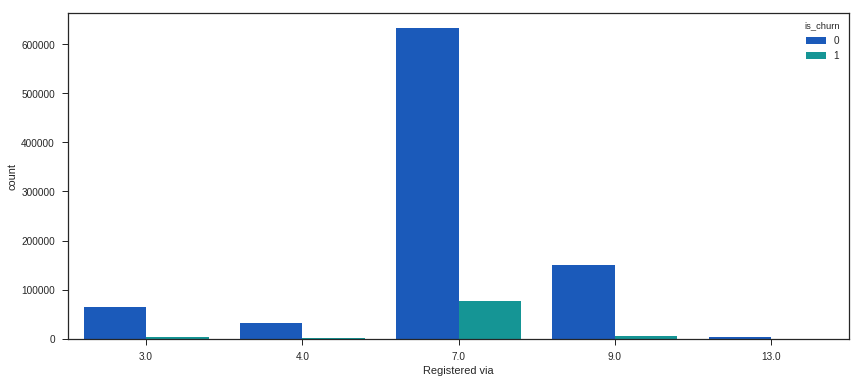

In [26]:
print('Number of unique value',train['registered_via'].unique())
plt.figure(figsize=(14,6))
sns.set_style('ticks')
sns.countplot(train['registered_via'],palette='summer')
plt.xlabel('Registered via')

plt.figure(figsize=(14,6))
sns.set_style('ticks')
sns.countplot(data=train ,x='registered_via',palette='winter',hue='is_churn')
plt.xlabel('Registered via')

# registration_init_time

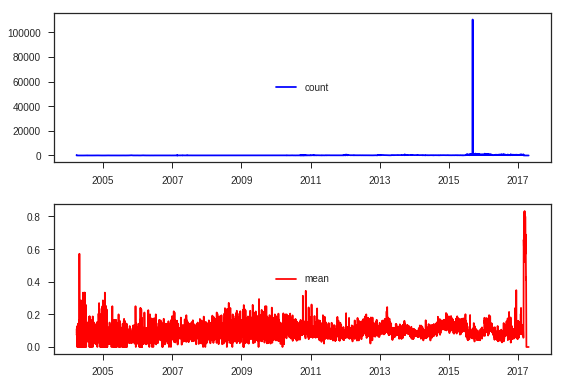

In [17]:
regi = train.groupby('registration_init_time').count()['is_churn']
plt.subplot(211)
plt.plot(regi,color='b',label='count')
plt.legend(loc='center')
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.subplot(212)
plt.plot(regi,color='r',label='mean')
plt.legend(loc='center')
plt.tight_layout()

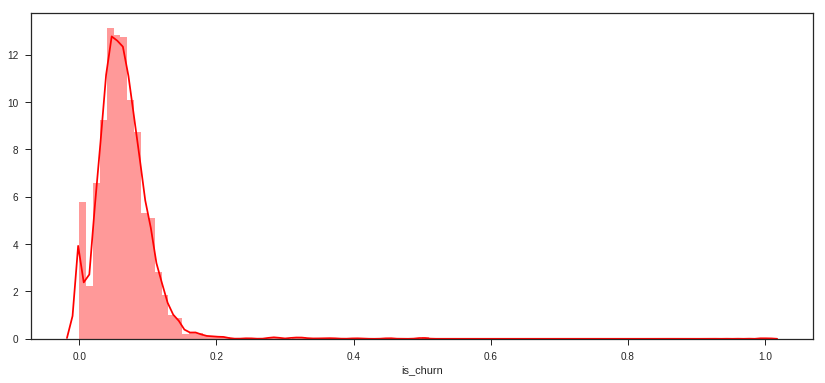

In [195]:
regi = train.groupby('registration_init_time').mean()['is_churn']
plt.figure(figsize=(14,6))
sns.distplot(regi,bins=100,color='r')

# reg_day

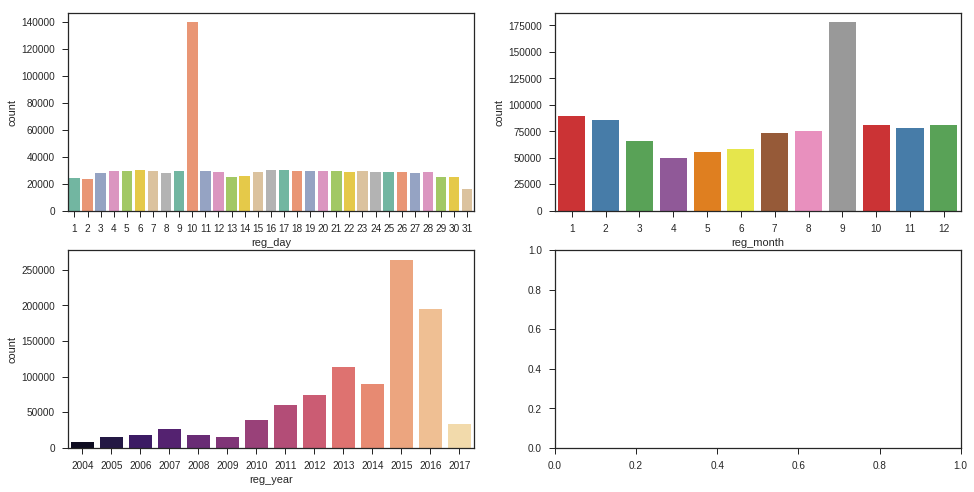

In [34]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['reg_day'],palette='Set2',ax=ax1)
sns.countplot(data=train,x='reg_month',palette='Set1',ax=ax2)
sns.countplot(data=train,x='reg_year',palette='magma',ax=ax3)
sns.

# reg_weekday

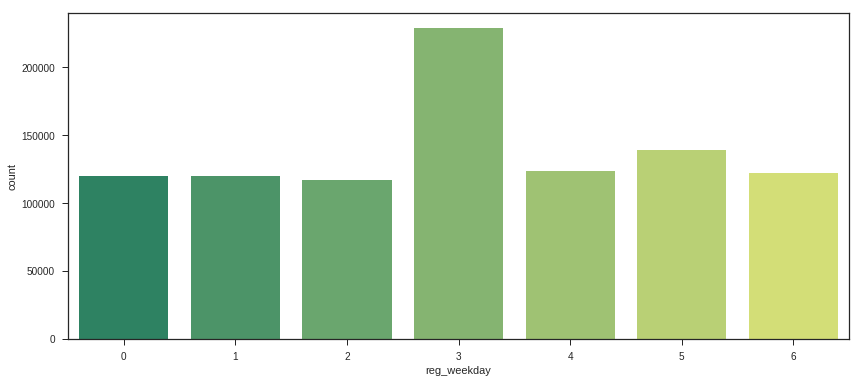

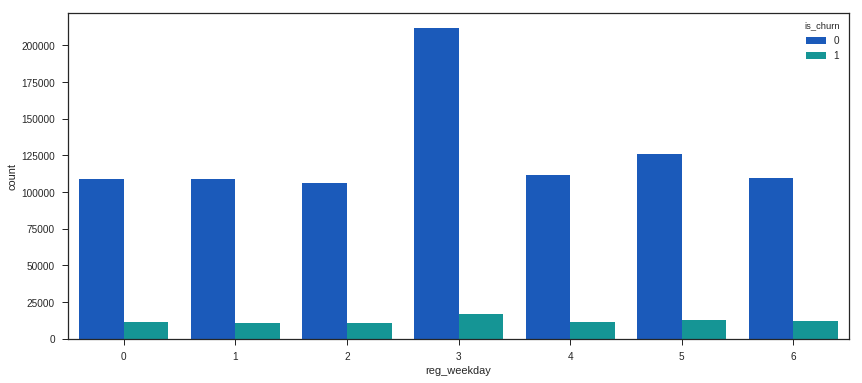

In [22]:
plt.figure(figsize=(14,6))
sns.countplot(train['reg_weekday'],palette='summer')

plt.figure(figsize=(14,6))
sns.countplot(data=train,x='reg_weekday',palette='winter',hue='is_churn')


In [38]:
cor = train1.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor,cmap='binary',annot=False)
plt.xticks(rotation=45)

NameError: name 'train1' is not defined

In [46]:
tf_idf = TfidfVectorizer(max_features=5,use_idf=True,lowercase=False,stop_words=None,analyzer='char',
                        ngram_range=(1, 3))

In [47]:
X_tf = tf_idf.fit_transform(train['msno']).toarray()

array([[ 0.        ,  0.26014842,  0.        ,  0.43176733,  0.86365489],
       [ 0.        ,  0.26013537,  0.86366965,  0.43174568,  0.        ],
       [ 0.        ,  0.51608195,  0.        ,  0.85653921,  0.        ],
       ..., 
       [ 0.        ,  0.39192126,  0.65060451,  0.65047021,  0.        ],
       [ 0.        ,  0.39192126,  0.65060451,  0.65047021,  0.        ],
       [ 0.54739857,  0.16476975,  0.54704838,  0.54693544,  0.2735058 ]])

# Encoder

In [49]:
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

# One Hot Encoding

In [29]:
def OHE(df):
    #col = df.select_dtypes(include=['category']).columns
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train)
test1 = OHE(test)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 61)
Categorical columns in dataset ['city', 'gender', 'registered_via']
(907471, 61)


In [41]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'reg_day', 'reg_weekday', 'reg_month', 'reg_year',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_year',
       'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month', 'mem_exp_year',
       'user__day', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

# Split data set

In [50]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train.drop(unwanted,axis=1)
y = train['is_churn'].astype('category')
x_test = test.drop(unwanted,axis=1)


## Hyper parameter tuning

In [60]:
log_reg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5,2,3]}
rs_cv = RandomizedSearchCV(estimator=log_reg,param_distributions=param,random_state=seed)
rs_cv.fit(X,y)
print('Best parameter :{} Best score :{}'.format(rs_cv.best_params_,rs_cv.best_score_))

Best parameter :{'C': 1} Best score :0.6499567438411469


# Logistic regression model with Stratified KFold split

In [62]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(class_weight='balanced',C=1)
    lr.fit(xtr,ytr)
    #score = roc_auc_score(yvl,lr.predict(xvl))
    score = lr.score(xvl,yvl)
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(x_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5
ROC AUC score: 0.605132938514
2 of KFold 5
ROC AUC score: 0.606734500991
3 of KFold 5


KeyboardInterrupt: 

In [66]:
ypred = lr.predict(X)
confusion_matrix(y,ypred)


array([[582408, 301222],
       [ 38978,  48352]])

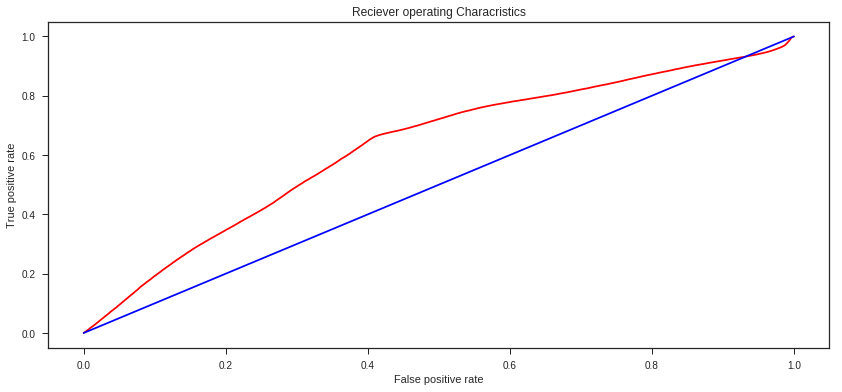

In [83]:
# y_proba = lr.predict_proba(X)[:,1]
fpr,tpr,th = roc_curve(y,y_proba)

plt.figure(figsize=(14,6))
plt.plot(fpr,tpr,color='r')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Characristics')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [86]:
cat_model = CatBoostClassifier(iterations=1000,
                               depth=7,
                               learning_rate=0.1,
                               loss_function='Logloss',
                              )

In [87]:
cat_model.fit(X,y)

0: learn: 0.593708	total: 2.54s	remaining: 42m 14s
1: learn: 0.5189576	total: 5.37s	remaining: 44m 39s
2: learn: 0.4646405	total: 7.86s	remaining: 43m 31s
3: learn: 0.4245544	total: 10.1s	remaining: 41m 58s
4: learn: 0.3933197	total: 12.2s	remaining: 40m 28s
5: learn: 0.3706729	total: 14.5s	remaining: 39m 56s
6: learn: 0.3503353	total: 17.1s	remaining: 40m 25s
7: learn: 0.337308	total: 19.3s	remaining: 39m 54s
8: learn: 0.3270198	total: 21.6s	remaining: 39m 35s
9: learn: 0.3161755	total: 24s	remaining: 39m 40s
10: learn: 0.310072	total: 27.2s	remaining: 40m 49s
11: learn: 0.3028527	total: 30.4s	remaining: 41m 43s
12: learn: 0.297131	total: 33.3s	remaining: 42m 4s
13: learn: 0.2932321	total: 35.7s	remaining: 41m 56s
14: learn: 0.291039	total: 38.1s	remaining: 41m 38s
15: learn: 0.2881449	total: 40.1s	remaining: 41m 7s
16: learn: 0.2856063	total: 42.5s	remaining: 40m 54s
17: learn: 0.2837513	total: 44.9s	remaining: 40m 51s
18: learn: 0.2825963	total: 49.1s	remaining: 42m 14s
19: learn: 0

153: learn: 0.2705422	total: 7m 25s	remaining: 40m 48s
154: learn: 0.2705116	total: 7m 28s	remaining: 40m 43s
155: learn: 0.2704989	total: 7m 30s	remaining: 40m 38s
156: learn: 0.2704899	total: 7m 33s	remaining: 40m 36s
157: learn: 0.2704737	total: 7m 37s	remaining: 40m 39s
158: learn: 0.2704663	total: 7m 41s	remaining: 40m 39s
159: learn: 0.2704565	total: 7m 43s	remaining: 40m 35s
160: learn: 0.2704503	total: 7m 46s	remaining: 40m 31s
161: learn: 0.2704362	total: 7m 49s	remaining: 40m 26s
162: learn: 0.2704238	total: 7m 51s	remaining: 40m 23s
163: learn: 0.2704099	total: 7m 55s	remaining: 40m 23s
164: learn: 0.2703993	total: 7m 58s	remaining: 40m 23s
165: learn: 0.2703884	total: 8m 2s	remaining: 40m 24s
166: learn: 0.27038	total: 8m 6s	remaining: 40m 24s
167: learn: 0.2703755	total: 8m 9s	remaining: 40m 23s
168: learn: 0.2703678	total: 8m 12s	remaining: 40m 20s
169: learn: 0.2703537	total: 8m 15s	remaining: 40m 19s
170: learn: 0.2703173	total: 8m 18s	remaining: 40m 18s
171: learn: 0.2

302: learn: 0.269271	total: 15m 14s	remaining: 35m 4s
303: learn: 0.2692625	total: 15m 18s	remaining: 35m 2s
304: learn: 0.269254	total: 15m 21s	remaining: 34m 58s
305: learn: 0.2692439	total: 15m 24s	remaining: 34m 56s
306: learn: 0.2692364	total: 15m 27s	remaining: 34m 53s
307: learn: 0.2692339	total: 15m 30s	remaining: 34m 50s
308: learn: 0.2692274	total: 15m 33s	remaining: 34m 47s
309: learn: 0.2692232	total: 15m 36s	remaining: 34m 44s
310: learn: 0.2692178	total: 15m 39s	remaining: 34m 41s
311: learn: 0.2692115	total: 15m 42s	remaining: 34m 39s
312: learn: 0.2692054	total: 15m 46s	remaining: 34m 37s
313: learn: 0.2691981	total: 15m 50s	remaining: 34m 36s
314: learn: 0.269195	total: 15m 53s	remaining: 34m 33s
315: learn: 0.2691914	total: 15m 56s	remaining: 34m 30s
316: learn: 0.269182	total: 15m 59s	remaining: 34m 27s
317: learn: 0.2691776	total: 16m 2s	remaining: 34m 25s
318: learn: 0.2691655	total: 16m 5s	remaining: 34m 21s
319: learn: 0.2691559	total: 16m 9s	remaining: 34m 19s
3

450: learn: 0.268319	total: 23m 14s	remaining: 28m 17s
451: learn: 0.268319	total: 23m 16s	remaining: 28m 13s
452: learn: 0.268316	total: 23m 20s	remaining: 28m 11s
453: learn: 0.2683101	total: 23m 24s	remaining: 28m 8s
454: learn: 0.2683089	total: 23m 27s	remaining: 28m 5s
455: learn: 0.2683014	total: 23m 30s	remaining: 28m 2s
456: learn: 0.2682964	total: 23m 33s	remaining: 27m 59s
457: learn: 0.2682958	total: 23m 37s	remaining: 27m 57s
458: learn: 0.2682944	total: 23m 40s	remaining: 27m 54s
459: learn: 0.2682884	total: 23m 44s	remaining: 27m 52s
460: learn: 0.268282	total: 23m 47s	remaining: 27m 48s
461: learn: 0.268281	total: 23m 50s	remaining: 27m 45s
462: learn: 0.268279	total: 23m 53s	remaining: 27m 42s
463: learn: 0.268278	total: 23m 56s	remaining: 27m 39s
464: learn: 0.268274	total: 23m 59s	remaining: 27m 36s
465: learn: 0.2682703	total: 24m 2s	remaining: 27m 33s
466: learn: 0.2682668	total: 24m 5s	remaining: 27m 29s
467: learn: 0.2682635	total: 24m 9s	remaining: 27m 27s
468: l

598: learn: 0.2676233	total: 31m 23s	remaining: 21m 1s
599: learn: 0.2676207	total: 31m 27s	remaining: 20m 58s
600: learn: 0.2676126	total: 31m 30s	remaining: 20m 54s
601: learn: 0.2676041	total: 31m 33s	remaining: 20m 51s
602: learn: 0.2676014	total: 31m 37s	remaining: 20m 49s
603: learn: 0.2675886	total: 31m 41s	remaining: 20m 46s
604: learn: 0.2675877	total: 31m 44s	remaining: 20m 43s
605: learn: 0.2675875	total: 31m 47s	remaining: 20m 40s
606: learn: 0.2675807	total: 31m 50s	remaining: 20m 36s
607: learn: 0.2675804	total: 31m 53s	remaining: 20m 33s
608: learn: 0.2675792	total: 31m 56s	remaining: 20m 30s
609: learn: 0.2675788	total: 31m 59s	remaining: 20m 27s
610: learn: 0.2675785	total: 32m 3s	remaining: 20m 24s
611: learn: 0.2675727	total: 32m 6s	remaining: 20m 21s
612: learn: 0.2675715	total: 32m 9s	remaining: 20m 18s
613: learn: 0.267567	total: 32m 13s	remaining: 20m 15s
614: learn: 0.2675622	total: 32m 17s	remaining: 20m 12s
615: learn: 0.2675607	total: 32m 20s	remaining: 20m 9

746: learn: 0.2670934	total: 39m 22s	remaining: 13m 20s
747: learn: 0.267092	total: 39m 26s	remaining: 13m 17s
748: learn: 0.2670876	total: 39m 30s	remaining: 13m 14s
749: learn: 0.2670836	total: 39m 34s	remaining: 13m 11s
750: learn: 0.2670833	total: 39m 38s	remaining: 13m 8s
751: learn: 0.2670815	total: 39m 42s	remaining: 13m 5s
752: learn: 0.2670742	total: 39m 47s	remaining: 13m 3s
753: learn: 0.2670716	total: 39m 53s	remaining: 13m
754: learn: 0.2670649	total: 39m 57s	remaining: 12m 57s
755: learn: 0.2670603	total: 40m 1s	remaining: 12m 55s
756: learn: 0.267059	total: 40m 6s	remaining: 12m 52s
757: learn: 0.2670589	total: 40m 10s	remaining: 12m 49s
758: learn: 0.2670573	total: 40m 14s	remaining: 12m 46s
759: learn: 0.2670566	total: 40m 19s	remaining: 12m 44s
760: learn: 0.2670555	total: 40m 24s	remaining: 12m 41s
761: learn: 0.2670535	total: 40m 29s	remaining: 12m 38s
762: learn: 0.2670533	total: 40m 33s	remaining: 12m 35s
763: learn: 0.2670522	total: 40m 36s	remaining: 12m 32s
764

895: learn: 0.2666833	total: 50m 8s	remaining: 5m 49s
896: learn: 0.2666806	total: 50m 11s	remaining: 5m 45s
897: learn: 0.2666796	total: 50m 15s	remaining: 5m 42s
898: learn: 0.2666796	total: 50m 16s	remaining: 5m 38s
899: learn: 0.2666795	total: 50m 19s	remaining: 5m 35s
900: learn: 0.2666793	total: 50m 23s	remaining: 5m 32s
901: learn: 0.2666739	total: 50m 26s	remaining: 5m 28s
902: learn: 0.266673	total: 50m 30s	remaining: 5m 25s
903: learn: 0.2666716	total: 50m 34s	remaining: 5m 22s
904: learn: 0.2666676	total: 50m 37s	remaining: 5m 18s
905: learn: 0.2666623	total: 50m 41s	remaining: 5m 15s
906: learn: 0.2666586	total: 50m 45s	remaining: 5m 12s
907: learn: 0.2666571	total: 50m 49s	remaining: 5m 8s
908: learn: 0.2666571	total: 50m 52s	remaining: 5m 5s
909: learn: 0.2666558	total: 50m 55s	remaining: 5m 2s
910: learn: 0.2666488	total: 50m 58s	remaining: 4m 58s
911: learn: 0.2666481	total: 51m 1s	remaining: 4m 55s
912: learn: 0.266647	total: 51m 4s	remaining: 4m 52s
913: learn: 0.2666

In [89]:
y_pred = cat_model.predict_proba(x_test)[:,1]
y_pred

array([ 0.02739503,  0.06041059,  0.07254662, ...,  0.0110864 ,
        0.07284732,  0.05235349])

# Model validation

In [28]:
print(cv_score)
print('\nMean accuracy',np.mean(cv_score))
confusion_matrix(yvl,lr.predict(xvl))

[0.5, 0.49999717076151784, 0.5, 0.5, 0.5]

Mean accuracy 0.499999434152


array([[176726,      0],
       [ 17466,      0]])

# Predict for unseen data set

In [90]:
#y_pred = pred_test_full/5
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
#submit.to_csv('kk_pred.csv',index=False)
submit.to_csv('kk_pred.csv.gz',index=False,compression='gzip')

In [ ]:
params = {'learning_rate':[0.01,0.03,0.1,0.3,1,],''}
xg_rscv = xgb.XGBClassifier()

clf = RandomizedSearchCV()

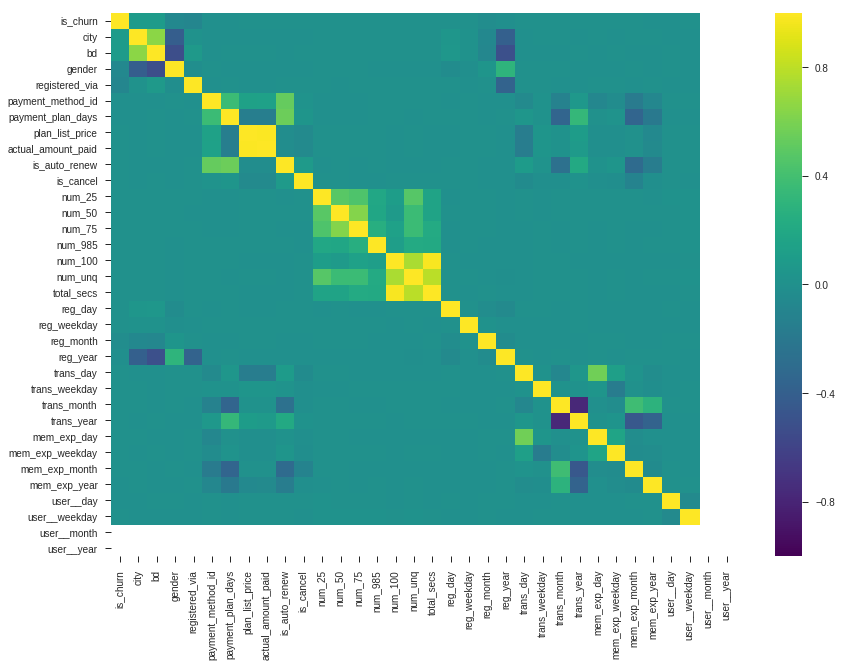

In [64]:
cor = train.corr()
fig,ax = plt.subplots(figsize=(14,10))
sns.heatmap(cor,cmap='viridis',ax=ax)

# XGBoost

In [110]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,num_rounds=100):
    params = {
        'objective':'binary:logistic',        
        'max_depth':7,
        'learning_rate':eta,
        'eval_metric':'logloss',
        'min_child_weight':10,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        #'reg_lambda':2,
        #'reg_alpha':2,
        #'gamma':1,
        #'scale_pos_weight':5,
        'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=20,verbose_eval=30)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model

In [98]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']
X = train.drop(unwanted,axis=1)
y = train['is_churn'].astype('category')
x_test = test.drop(unwanted,axis=1)

In [112]:
kf = StratifiedKFold(n_splits=3,random_state=seed)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
        
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=1000,eta=0.07)    
    pred_test_full += pred_test
    cv_score.append(xg_model.best_score)
    i+=1


1 of KFold 3
[0]	train-logloss:0.646267	test-logloss:0.646309
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 20 rounds.
[30]	train-logloss:0.287896	test-logloss:0.289204
[60]	train-logloss:0.269695	test-logloss:0.272655
[90]	train-logloss:0.267227	test-logloss:0.271696
[120]	train-logloss:0.266194	test-logloss:0.271647
Stopping. Best iteration:
[101]	train-logloss:0.266797	test-logloss:0.271625

2 of KFold 3
[0]	train-logloss:0.646249	test-logloss:0.646292
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 20 rounds.


KeyboardInterrupt: 

In [101]:
print(cv_score)
print('Mean cv score',np.mean(cv_score))

[0.272294, 0.272141, 0.272393]
Mean cv score 0.272276


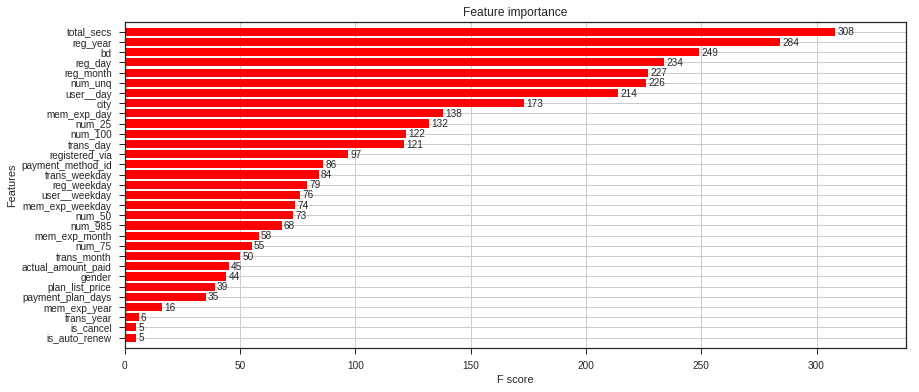

In [102]:
fig,ax = plt.subplots(figsize=(14,6))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

# Predict for unseen data set

In [103]:
y_pred = pred_test_full/3
submit = pd.DataFrame({'msno':test['msno'],'is_churn':y_pred})
#submit.to_csv('kk_pred.csv',index=False)
submit.to_csv('kk_pred.csv.gz',index=False,compression='gzip')


# Thank you for visiting